In [7]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv(r".\backend\.env")

# add to path
import sys
sys.path.append(r".\backend")

# %load_ext autoreload
# %autoreload 2

### Connect to Qdrant


In [8]:
from app.semantic_search import vector_client, QDRANT_COLLECTION_NAME
from app.semantic_search.embedding import TextEmbeddingGenerator

### Retrieve items from db to df

In [10]:
from app import models, schemas
from app.database import get_db, get_meili_index
from sqlalchemy.orm import Session
from typing import List


db = next(get_db())

# retrieve products from db
def get_products(item_ids: List[int]):
    """Get all products from the database with the specified item IDs."""
    products = db.query(models.Item).filter(models.Item.id.in_(item_ids)).all()
    items = [item.as_dict() for item in products]
    items_df = pd.DataFrame(items)
    items_df.rename(columns={"id": "db_id"}, inplace=True)
    return items_df

get_products([361])

,db_id,name,description,main_category,sub_category,image_url,stock_quantity,price,created_at,is_deleted
0,361,solid wood platform bed,"good , deep sleep can be quite difficult to ha...",Beds,,https://cdn-icons-png.flaticon.com/256/8787/87...,5,5.99,2023-12-26T14:35:32.184675+00:00,False


In [87]:
query_df = pd.read_csv("data_eval_prepared/query_cleaned.csv", sep='\t')
labels_df = pd.read_csv("WANDS/dataset/label.csv", sep='\t')
product_df = pd.read_csv("data_eval_prepared/product_cleaned.csv", sep='\t')

# add item name to labels df
labels_df = labels_df.merge(product_df[["product_id", "product_name"]], left_on="product_id", right_on="product_id")

## Vector search

search_field = "title" | "title_descr"

title - search only in title
title_descr - search in title and description

In [108]:
import os

TEXT_EMBEDDING_MODEL = os.getenv("TEXT_EMBEDDING_MODEL")
text_embedding_generator = TextEmbeddingGenerator(model_name=TEXT_EMBEDDING_MODEL)


def search_vector(query_id: int, search_field: str = "title", top_k: int = 10):
    """Search for items in the database."""
    query = query_df[query_df["query_id"] == query_id]["query"].values[0]
    # print(f"Searching for: {query}")
    # generate query vector
    query_vector = text_embedding_generator.generate_embedding(query)
    # search for items
    results = vector_client.search(QDRANT_COLLECTION_NAME, query_vector=query_vector, search_type=search_field, top_k=top_k)
    
    # prep results
    res_df = pd.DataFrame(results)
    products_df = get_products(res_df["item_id"].tolist())
    products_df = products_df.rename(columns={"id": "db_id"})
    res_df = products_df.merge(res_df, left_on="db_id", right_on="item_id")
    
    # sort by score
    res_df = res_df.sort_values(by="score", ascending=False)
    # drop columns
    res_df = res_df[["db_id", "item_id", "score", "name", "description", "main_category", "image_url"]]  

    # merge with labels df and query df
    labels = labels_df[labels_df["query_id"] == query_id]
    res_df = res_df.merge(labels, left_on="name", right_on="product_name", how="left")
    
    # retrieve only relevant columns
    res_df = res_df[["score", "label", "query_id", "name", "description", "main_category", "image_url", "db_id"]]
    res_df["label"] = res_df["label"].fillna("Unknown") # Query product relation not defined in dataset
    res_df = res_df.drop_duplicates()
    return res_df, query_id


res_df, query_id = search_vector(215, search_field="title_descr", top_k=15)
res_df.sort_values(by="score", ascending=False)

,score,label,query_id,name,description,main_category,image_url,db_id
0,0.609701,Partial,215,14 '' adjustable bed base with wireless remote,we set out to create a quality and reliable ad...,Adjustable Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,587
1,0.608512,Partial,215,adjustable bed frame,looking to upgrade a tired bedframe ? or are y...,Bed Frames,https://cdn-icons-png.flaticon.com/256/8787/87...,2195
3,0.605916,Partial,215,caulkins heavy duty adjustable metal bed frame...,set a simplistic foundation for your restful r...,Bed Frames|Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,2263
5,0.602996,Partial,215,adjustable-size bed frame,set a practical foundation for your guest room...,Bed Frames|Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,2207
7,0.599622,Partial,215,8 piece adjustable bed riser set,keep your bed propped up with these sturdy and...,Bed Accessories,https://cdn-icons-png.flaticon.com/256/8787/87...,32292
9,0.598194,Partial,215,adjustable bed base,"adjustable bed base with wireless remote , dua...",Adjustable Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,28561
10,0.580596,Partial,215,head-foot model-good adjustable bed base,rise to new heights and get the sleep you 've ...,Adjustable Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,15864
11,0.575197,Partial,215,comfort adjustable bed base,this comfortable adjustable bed base is the pe...,Adjustable Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,7967
12,0.570252,Partial,215,kira 13 '' massaging zero gravity adjustable b...,white noise adjustable beds offer a host of lu...,Adjustable Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,35314
13,0.568816,Partial,215,tahmid king standard bed,the bedroom collection offers sophisticated lo...,Beds,https://cdn-icons-png.flaticon.com/256/8787/87...,16970


## Classic search 

Meilisearch is used for classic search

In [104]:
from typing import Tuple

items_index = get_meili_index()
no_results_classic_title_descr = 0

def classic_search(query_id: int, top_k: int = 10, fields: tuple = ("name", "description")):
        # https://www.meilisearch.com/docs/reference/api/search
    global no_results_classic_title_descr  # Add this line to access the global variable
    query = query_df[query_df["query_id"] == query_id]["query"].values[0]
    # print(f"Searching for: {query}")
    
    result = items_index.search(
        query,
        {
            'matchingStrategy': 'last',
            'limit': top_k,
            "attributesToSearchOn": list(fields),
            "showRankingScore": True
        }
    )
    
    res_df = pd.DataFrame(result["hits"])
    if res_df.shape[0] == 0:
        print("No results for query in classic search: ", query)
        no_results_classic_title_descr += 1
        return pd.DataFrame(columns=["db_id", "score", "label", "name", "description", "main_category", "image_url"]), query_id
    res_df = res_df.rename(columns={"id": "db_id", "_rankingScore": "score"})
    products_df = get_products(res_df["db_id"].tolist())
    res_df = res_df[["db_id", "score"]]
    res_df = products_df.merge(res_df, left_on="db_id", right_on="db_id")
    res_df = res_df.sort_values(by="score", ascending=False)
    res_df = res_df[["db_id", "score", "name", "description", "main_category", "image_url"]]
        
    # merge with labels df and query df
    labels = labels_df[labels_df["query_id"] == query_id]
    res_df = res_df.merge(labels, left_on="name", right_on="product_name", how="left")
    res_df = res_df[["db_id", "score", "label", "name", "description", "main_category", "image_url"]]
    res_df["label"] = res_df["label"].fillna("Unknown") # relation not defined in dataset 
    res_df["query_id"] = query_id
    res_df = res_df.drop_duplicates()
    return res_df, query_id

res_df, query_id = classic_search(351, top_k=15, fields=("name", "description"))
res_df

items_eval_V2


,db_id,score,label,name,description,main_category,image_url,query_id
0,38682,0.983294,Partial,edenderry 30 '' single bathroom vanity,simplify those rushed mornings with the timele...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
1,33129,0.975254,Partial,braylen sliding barn door 36 '' single bathroo...,this single bathroom vanity set brings coastal...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
2,5170,0.949960,Partial,corburn 30 '' single bathroom vanity,a good product with two birds with one stone ....,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
3,15149,0.945365,Partial,samoset 72 '' double bathroom vanity base only,round out your bathroom ensemble with a stylis...,Vanity Bases,https://cdn-icons-png.flaticon.com/256/8787/87...,351
4,34798,0.779090,Partial,friedland 30.5 '' single bathroom vanity set,live with the freedom and reassurance of knowi...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
5,34800,0.779090,Partial,aleksandra 49 '' single bathroom vanity set,live with the freedom and reassurance of knowi...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
6,6353,0.773649,Partial,32 '' single bathroom vanity set,a cost-effective modern style bathroom vanity ...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
7,16751,0.773649,Partial,49 '' double bathroom vanity round with sink,add a luxurious touch to your space with this ...,Vanity Tops,https://cdn-icons-png.flaticon.com/256/8787/87...,351
8,18743,0.773646,Partial,martinsville 36 '' single sink bathroom vanity...,enjoy a sense of warmth in your bathroom with ...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351
9,35674,0.773643,Partial,ellaline 42 '' single bathroom vanity,traditional charm meets coastal flair with thi...,Vanities,https://cdn-icons-png.flaticon.com/256/8787/87...,351


## CONFIG

In [16]:
top_k = 15

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot(df, columns, labels, colors, xlabel='Count of items', ylabel='Density', title='TOP15 products retrieval', cut=0):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Plot kernel density plots with dots for each column
    for col, label, color in zip(columns, labels, colors):
        sns.histplot(df[col], label=label, color=color, bins=15, stat='count', element='step')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

In [115]:
from tqdm import tqdm 
tqdm.pandas()

def count_labels(df, query_id):
    if df.shape[0] == 0:
        return {
            "Irrelevant": 0,
            "Partial": 0,
            "Exact": 0,
            "Unknown": 0,
            "query_id": query_id
        }
    res = df["label"].value_counts().to_dict()
    res["query_id"] = query_id
    return res

## Search with Title + Description

#### Vector

In [158]:
res_vector_title_descr = query_df["query_id"].progress_apply(lambda q_id: count_labels(*search_vector(q_id, search_field="title_descr", top_k=top_k)))
res_vector_title_descr

100%|██████████| 474/474 [00:19<00:00, 24.87it/s]


0      {'Partial': 8, 'Exact': 6, 'Irrelevant': 1, 'q...
1        {'Partial': 14, 'Irrelevant': 1, 'query_id': 1}
2                           {'Exact': 15, 'query_id': 2}
3      {'Exact': 7, 'Partial': 5, 'Irrelevant': 3, 'q...
4            {'Unknown': 8, 'Partial': 7, 'query_id': 4}
                             ...                        
469         {'Partial': 14, 'Exact': 1, 'query_id': 483}
470                     {'Partial': 15, 'query_id': 484}
471    {'Irrelevant': 6, 'Unknown': 6, 'Partial': 3, ...
472        {'Partial': 8, 'Unknown': 7, 'query_id': 486}
473    {'Unknown': 14, 'Irrelevant': 1, 'query_id': 487}
Name: query_id, Length: 474, dtype: object

In [159]:
res_vector_title_descr = pd.DataFrame(res_vector_title_descr.tolist())
res_vector_title_descr = res_vector_title_descr.fillna(0)
res_vector_title_descr["query_id"] = query_df["query_id"].astype(int)
res_vector_title_descr = res_vector_title_descr[["query_id","Irrelevant","Partial","Exact","Unknown"]]
res_vector_title_descr

,query_id,Irrelevant,Partial,Exact,Unknown
0,0,1.0,8.0,6.0,0.0
1,1,1.0,14.0,0.0,0.0
2,2,0.0,0.0,15.0,0.0
3,3,3.0,5.0,7.0,0.0
4,4,0.0,7.0,0.0,8.0
...,...,...,...,...,...
469,483,0.0,14.0,1.0,0.0
470,484,0.0,15.0,0.0,0.0
471,485,6.0,3.0,0.0,6.0
472,486,0.0,8.0,0.0,7.0


In [160]:
res_vector_title_descr.describe()

,query_id,Irrelevant,Partial,Exact,Unknown
count,474.000000,474.000000,474.000000,474.000000,474.000000
mean,243.069620,0.491561,6.717300,4.710970,3.080169
std,142.112294,1.449988,5.410841,5.489834,4.304222
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.250000,0.000000,1.000000,0.000000,0.000000
50%,246.500000,0.000000,6.000000,2.000000,1.000000
75%,366.750000,0.000000,12.000000,10.000000,5.000000
max,487.000000,14.000000,15.000000,15.000000,15.000000


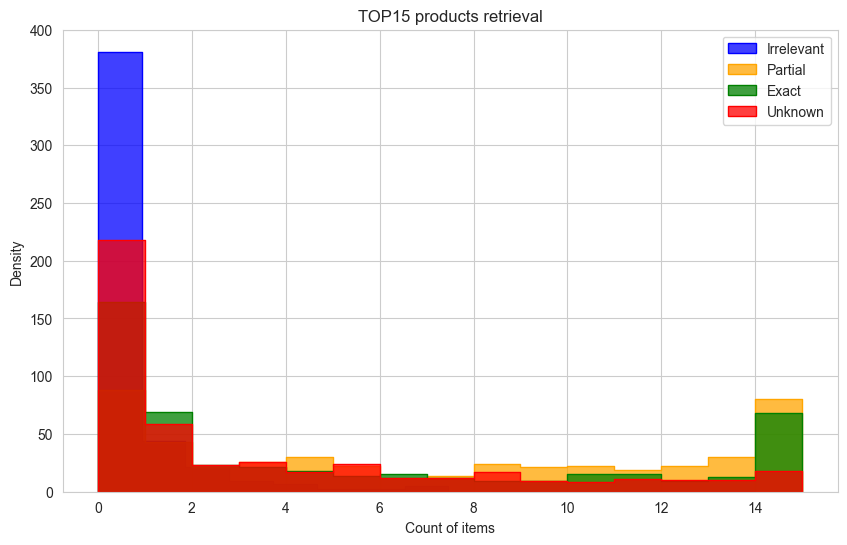

In [130]:
label_names = ['Irrelevant', 'Partial', 'Exact', "Unknown"]
color_palette = ['blue', 'orange', 'green', "red"]

plot(res_vector_title_descr, label_names, label_names, color_palette)

In [161]:
# ALL 
irrelevant_sum = res_vector_title_descr["Irrelevant"].sum()
partial_sum = res_vector_title_descr["Partial"].sum()
exact_sum = res_vector_title_descr["Exact"].sum()
unknown_sum = res_vector_title_descr["Unknown"].sum()
sum_all = irrelevant_sum + partial_sum + exact_sum + unknown_sum

# Irrelevant
print("VECTOR SEARCH - TITLE + DESCRIPTION")
print("Task was to retrieve TOP 15 products for each query")
print("--- --- --- ")
print("Irrelevant: ", irrelevant_sum, "/", sum_all, " = ", irrelevant_sum/sum_all)
print("Partial: ", partial_sum, "/", sum_all, " = ", partial_sum/sum_all)
print("Exact: ", exact_sum, "/", sum_all, " = ", exact_sum/sum_all)
print("Unknown: ", unknown_sum, "/", sum_all, " = ", unknown_sum/sum_all)
print("ALL: ", sum_all, "/", query_df.shape[0] * top_k, " = ", sum_all/(query_df.shape[0] * top_k))
print("--- without Unknown ---")
print("Irrelevant: ", irrelevant_sum, "/", sum_all - unknown_sum, " = ", irrelevant_sum/(sum_all - unknown_sum))
print("Partial: ", partial_sum, "/", sum_all - unknown_sum, " = ", partial_sum/(sum_all - unknown_sum))
print("Exact: ", exact_sum, "/", sum_all - unknown_sum, " = ", exact_sum/(sum_all - unknown_sum))

VECTOR SEARCH - TITLE + DESCRIPTION
Task was to retrieve TOP 15 products for each query
--- --- --- 
Irrelevant:  233.0 / 7110.0  =  0.03277074542897328
Partial:  3184.0 / 7110.0  =  0.4478199718706048
Exact:  2233.0 / 7110.0  =  0.3140646976090014
Unknown:  1460.0 / 7110.0  =  0.20534458509142053
ALL:  7110.0 / 7110  =  1.0
--- without Unknown ---
Irrelevant:  233.0 / 5650.0  =  0.04123893805309734
Partial:  3184.0 / 5650.0  =  0.5635398230088495
Exact:  2233.0 / 5650.0  =  0.3952212389380531


---

#### Classic

In [92]:
query_df.iloc[78]

query_id                 78
query          dorel vanity
query_class        Vanities
Name: 78, dtype: object

In [134]:
res_classic_title_descr = query_df["query_id"].progress_apply(lambda q_id: count_labels(*classic_search(q_id, top_k=top_k, fields=("name", "description"))))

 17%|█▋        | 81/474 [00:02<00:09, 39.33it/s]

No results for query in classic search:  sancroft armchair


 20%|█▉        | 94/474 [00:02<00:10, 34.71it/s]

No results for query in classic search:  vlad modular sectional
No results for query in classic search:  filaret outdoor sofa


 41%|████      | 195/474 [00:06<00:08, 32.61it/s]

No results for query in classic search:  biycicle plant stands
No results for query in classic search:  chabely 5 draw chest


 44%|████▎     | 207/474 [00:06<00:09, 28.03it/s]

No results for query in classic search:  fawkes 36" blue vanity


 56%|█████▋    | 267/474 [00:08<00:06, 34.49it/s]

No results for query in classic search:  donaldson teak couch


 59%|█████▉    | 281/474 [00:08<00:05, 37.32it/s]

No results for query in classic search:  48" sliding single track , barn door for laundry


 76%|███████▌  | 359/474 [00:10<00:03, 36.99it/s]

No results for query in classic search:  drudge report


 78%|███████▊  | 372/474 [00:11<00:02, 36.23it/s]

No results for query in classic search:  cliffside 5 light candle style drum chandelier


 83%|████████▎ | 392/474 [00:11<00:02, 36.68it/s]

No results for query in classic search:  maryford queen tufted bed


 96%|█████████▌| 453/474 [00:13<00:00, 37.72it/s]

No results for query in classic search:  tye dye duvet cover


100%|██████████| 474/474 [00:14<00:00, 33.73it/s]

No results for query in classic search:  pedistole sink


In [135]:
res_classic_title_descr = pd.DataFrame(res_classic_title_descr.tolist())
res_classic_title_descr = res_classic_title_descr.fillna(0)
res_classic_title_descr["query_id"] = query_df["query_id"].astype(int)
res_classic_title_descr = res_classic_title_descr[[
    "query_id",
    "Irrelevant",
    "Partial",
    "Exact",
    "Unknown"
]]

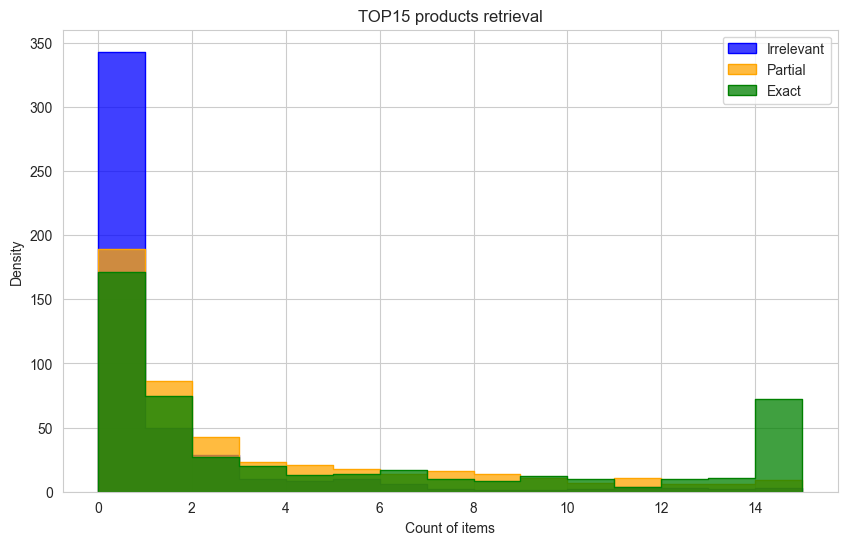

In [136]:
columns_to_plot = ['Irrelevant', 'Partial', 'Exact']
label_names = ['Irrelevant', 'Partial', 'Exact']
color_palette = ['blue', 'orange', 'green']

plot(res_classic_title_descr, columns_to_plot, label_names, color_palette)

In [151]:
# ALL 
irrelevant_sum = res_classic_title_descr["Irrelevant"].sum()
partial_sum = res_classic_title_descr["Partial"].sum()
exact_sum = res_classic_title_descr["Exact"].sum()
unknown_sum = res_classic_title_descr["Unknown"].sum()
sum_all = irrelevant_sum + partial_sum + exact_sum + unknown_sum

# Irrelevant
print("CLASSIC SEARCH - TITLE + DESCRIPTION")
print("Task was to retrieve TOP 15 products for each query")
print("Missing results: ", sum_all, "/", query_df.shape[0] * top_k, " = ", sum_all/(query_df.shape[0] * top_k))
print("--- --- --- ")
print("Irrelevant: ", irrelevant_sum, "/", sum_all, " = ", irrelevant_sum/sum_all)
print("Partial: ", partial_sum, "/", sum_all, " = ", partial_sum/sum_all)
print("Exact: ", exact_sum, "/", sum_all, " = ", exact_sum/sum_all)
print("Unknown: ", unknown_sum, "/", sum_all, " = ", unknown_sum/sum_all)
print("--- without Unknown ---")
print("Irrelevant: ", irrelevant_sum, "/", sum_all - unknown_sum, " = ", irrelevant_sum/(sum_all - unknown_sum))
print("Partial: ", partial_sum, "/", sum_all - unknown_sum, " = ", partial_sum/(sum_all - unknown_sum))
print("Exact: ", exact_sum, "/", sum_all - unknown_sum, " = ", exact_sum/(sum_all - unknown_sum))

CLASSIC SEARCH - TITLE + DESCRIPTION
Task was to retrieve TOP 15 products for each query
Missing results:  5763.0 / 7110  =  0.8105485232067511
--- --- --- 
Irrelevant:  791.0 / 5763.0  =  0.13725490196078433
Partial:  1244.0 / 5763.0  =  0.21585979524553184
Exact:  1925.0 / 5763.0  =  0.334027416276245
Unknown:  1803.0 / 5763.0  =  0.31285788651743884
--- without Unknown ---
Irrelevant:  791.0 / 3960.0  =  0.19974747474747476
Partial:  1244.0 / 3960.0  =  0.31414141414141417
Exact:  1925.0 / 3960.0  =  0.4861111111111111


## Search with only Title

#### Vector

In [153]:
res_vector_title = query_df["query_id"].progress_apply(lambda q_id: count_labels(*search_vector(q_id, search_field="title", top_k=top_k)))
res_vector_title

100%|██████████| 474/474 [00:22<00:00, 20.88it/s]


0      {'Partial': 9, 'Exact': 5, 'Irrelevant': 1, 'q...
1             {'Partial': 13, 'Exact': 2, 'query_id': 1}
2      {'Exact': 13, 'Partial': 1, 'Irrelevant': 1, '...
3      {'Partial': 8, 'Exact': 6, 'Unknown': 1, 'quer...
4      {'Partial': 9, 'Unknown': 4, 'Irrelevant': 1, ...
                             ...                        
469                     {'Partial': 15, 'query_id': 483}
470                     {'Partial': 15, 'query_id': 484}
471    {'Unknown': 6, 'Partial': 6, 'Irrelevant': 3, ...
472       {'Partial': 10, 'Unknown': 5, 'query_id': 486}
473       {'Unknown': 14, 'Partial': 1, 'query_id': 487}
Name: query_id, Length: 474, dtype: object

In [154]:
res_vector_title = pd.DataFrame(res_vector_title.tolist())
res_vector_title = res_vector_title.fillna(0)
res_vector_title["query_id"] = query_df["query_id"].astype(int)
res_vector_title = res_vector_title[["query_id","Irrelevant","Partial","Exact","Unknown"]]
res_vector_title

,query_id,Irrelevant,Partial,Exact,Unknown
0,0,1.0,9.0,5.0,0.0
1,1,0.0,13.0,2.0,0.0
2,2,1.0,1.0,13.0,0.0
3,3,0.0,8.0,6.0,1.0
4,4,1.0,9.0,1.0,4.0
...,...,...,...,...,...
469,483,0.0,15.0,0.0,0.0
470,484,0.0,15.0,0.0,0.0
471,485,3.0,6.0,0.0,6.0
472,486,0.0,10.0,0.0,5.0


In [155]:
res_vector_title.describe()

,query_id,Irrelevant,Partial,Exact,Unknown
count,474.000000,474.000000,474.000000,474.00000,474.000000
mean,243.069620,0.550633,7.508439,4.50000,2.445148
std,142.112294,1.547886,5.528031,5.44946,4.103078
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,118.250000,0.000000,2.000000,0.00000,0.000000
50%,246.500000,0.000000,8.000000,1.00000,0.000000
75%,366.750000,0.000000,13.000000,9.00000,3.000000
max,487.000000,15.000000,15.000000,15.00000,15.000000


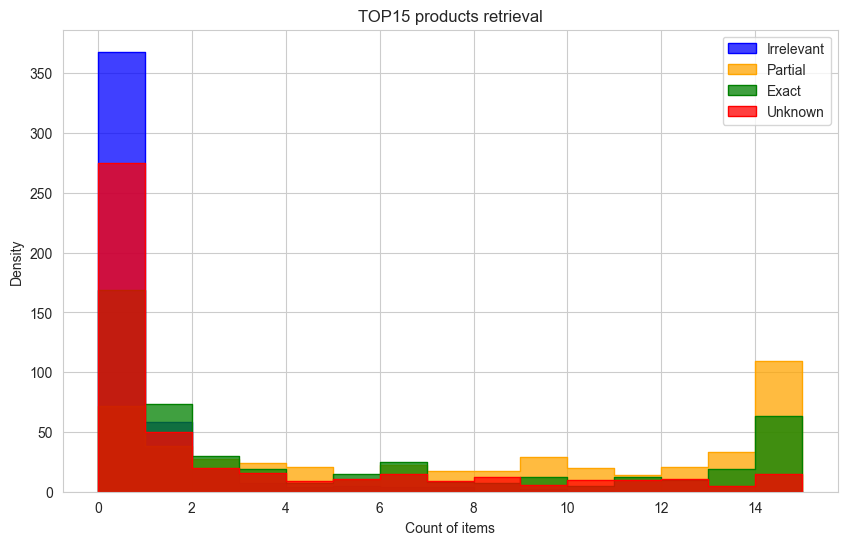

In [144]:
label_names = ['Irrelevant', 'Partial', 'Exact', "Unknown"]
color_palette = ['blue', 'orange', 'green', "red"]

plot(res_vector_title, label_names, label_names, color_palette)

In [157]:
# ALL 
irrelevant_sum = res_vector_title["Irrelevant"].sum()
partial_sum = res_vector_title["Partial"].sum()
exact_sum = res_vector_title["Exact"].sum()
unknown_sum = res_vector_title["Unknown"].sum()
sum_all = irrelevant_sum + partial_sum + exact_sum + unknown_sum

# Irrelevant
print("VECTOR SEARCH - TITLE")
print("Task was to retrieve TOP 15 products for each query")
print("--- --- --- ")
print("Irrelevant: ", irrelevant_sum, "/", sum_all, " = ", irrelevant_sum/sum_all)
print("Partial: ", partial_sum, "/", sum_all, " = ", partial_sum/sum_all)
print("Exact: ", exact_sum, "/", sum_all, " = ", exact_sum/sum_all)
print("Unknown: ", unknown_sum, "/", sum_all, " = ", unknown_sum/sum_all)
print("ALL: ", sum_all, "/", query_df.shape[0] * top_k, " = ", sum_all/(query_df.shape[0] * top_k))
print("--- without Unknown ---")
print("Irrelevant: ", irrelevant_sum, "/", sum_all - unknown_sum, " = ", irrelevant_sum/(sum_all - unknown_sum))
print("Partial: ", partial_sum, "/", sum_all - unknown_sum, " = ", partial_sum/(sum_all - unknown_sum))
print("Exact: ", exact_sum, "/", sum_all - unknown_sum, " = ", exact_sum/(sum_all - unknown_sum))

VECTOR SEARCH - TITLE
Task was to retrieve TOP 15 products for each query
--- --- --- 
Irrelevant:  261.0 / 7112.0  =  0.036698537682789655
Partial:  3559.0 / 7112.0  =  0.500421822272216
Exact:  2133.0 / 7112.0  =  0.2999156355455568
Unknown:  1159.0 / 7112.0  =  0.16296400449943757
ALL:  7112.0 / 7110  =  1.0002812939521801
--- without Unknown ---
Irrelevant:  261.0 / 5953.0  =  0.04384344028221065
Partial:  3559.0 / 5953.0  =  0.5978498236183437
Exact:  2133.0 / 5953.0  =  0.35830673609944563


---

#### Classic

In [162]:
res_classic_title = query_df["query_id"].progress_apply(lambda q_id: count_labels(*classic_search(q_id, top_k=top_k, fields=("name", ))))

  5%|▌         | 25/474 [00:00<00:10, 41.12it/s]

No results for query in classic search:  blk 18x18 seat cushions
No results for query in classic search:  foutains with brick look


 18%|█▊        | 85/474 [00:02<00:08, 47.00it/s]

No results for query in classic search:  sancroft armchair
No results for query in classic search:  vlad modular sectional


 20%|██        | 95/474 [00:02<00:08, 43.36it/s]

No results for query in classic search:  filaret outdoor sofa


 34%|███▍      | 160/474 [00:03<00:07, 42.01it/s]

No results for query in classic search:  wishbone chair


 37%|███▋      | 175/474 [00:04<00:07, 42.52it/s]

No results for query in classic search:  nectar queen mattress


 42%|████▏     | 197/474 [00:04<00:05, 47.55it/s]

No results for query in classic search:  biycicle plant stands
No results for query in classic search:  chabely 5 draw chest


 45%|████▍     | 212/474 [00:05<00:05, 45.18it/s]

No results for query in classic search:  fawkes 36" blue vanity


 57%|█████▋    | 268/474 [00:06<00:04, 45.99it/s]

No results for query in classic search:  donaldson teak couch


 60%|█████▉    | 284/474 [00:06<00:04, 46.03it/s]

No results for query in classic search:  48" sliding single track , barn door for laundry


 71%|███████   | 335/474 [00:07<00:02, 49.13it/s]

No results for query in classic search:  iittala bowl


 76%|███████▌  | 361/474 [00:08<00:02, 48.78it/s]

No results for query in classic search:  drudge report
No results for query in classic search:  togo chair


 79%|███████▉  | 376/474 [00:08<00:02, 44.98it/s]

No results for query in classic search:  cliffside 5 light candle style drum chandelier


 84%|████████▎ | 396/474 [00:09<00:01, 45.93it/s]

No results for query in classic search:  maryford queen tufted bed


 95%|█████████▌| 451/474 [00:10<00:00, 41.66it/s]

No results for query in classic search:  tye dye duvet cover


100%|██████████| 474/474 [00:10<00:00, 43.23it/s]

No results for query in classic search:  pedistole sink


In [164]:
res_classic_title = pd.DataFrame(res_classic_title.tolist())
res_classic_title = res_classic_title.fillna(0)
res_classic_title["query_id"] = query_df["query_id"].astype(int)
res_classic_title = res_classic_title[[
    "query_id",
    "Irrelevant",
    "Partial",
    "Exact",
    "Unknown"
]]

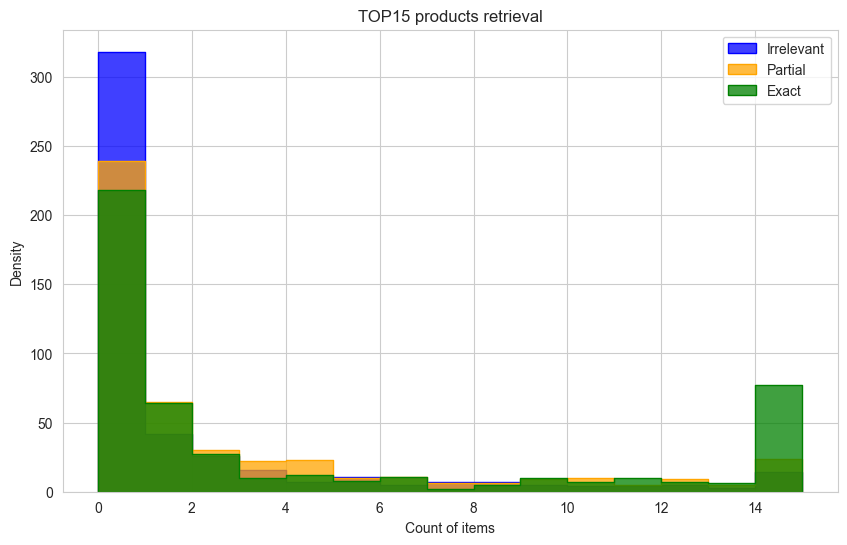

In [148]:
columns_to_plot = ['Irrelevant', 'Partial', 'Exact']
label_names = ['Irrelevant', 'Partial', 'Exact']
color_palette = ['blue', 'orange', 'green']

plot(res_classic_title, columns_to_plot, label_names, color_palette)

In [166]:
# ALL 
irrelevant_sum = res_classic_title["Irrelevant"].sum()
partial_sum = res_classic_title["Partial"].sum()
exact_sum = res_classic_title["Exact"].sum()
unknown_sum = res_classic_title["Unknown"].sum()
sum_all = irrelevant_sum + partial_sum + exact_sum + unknown_sum

# Irrelevant
print("CLASSIC SEARCH - TITLE")
print("Task was to retrieve TOP 15 products for each query")
print("Missing results: ", sum_all, "/", query_df.shape[0] * top_k, " = ", sum_all/(query_df.shape[0] * top_k))
print("--- --- --- ")
print("Irrelevant: ", irrelevant_sum, "/", sum_all, " = ", irrelevant_sum/sum_all)
print("Partial: ", partial_sum, "/", sum_all, " = ", partial_sum/sum_all)
print("Exact: ", exact_sum, "/", sum_all, " = ", exact_sum/sum_all)
print("Unknown: ", unknown_sum, "/", sum_all, " = ", unknown_sum/sum_all)
print("--- without Unknown ---")
print("Irrelevant: ", irrelevant_sum, "/", sum_all - unknown_sum, " = ", irrelevant_sum/(sum_all - unknown_sum))
print("Partial: ", partial_sum, "/", sum_all - unknown_sum, " = ", partial_sum/(sum_all - unknown_sum))
print("Exact: ", exact_sum, "/", sum_all - unknown_sum, " = ", exact_sum/(sum_all - unknown_sum))

CLASSIC SEARCH - TITLE
Task was to retrieve TOP 15 products for each query
Missing results:  5763.0 / 7110  =  0.8105485232067511
--- --- --- 
Irrelevant:  791.0 / 5763.0  =  0.13725490196078433
Partial:  1244.0 / 5763.0  =  0.21585979524553184
Exact:  1925.0 / 5763.0  =  0.334027416276245
Unknown:  1803.0 / 5763.0  =  0.31285788651743884
--- without Unknown ---
Irrelevant:  791.0 / 3960.0  =  0.19974747474747476
Partial:  1244.0 / 3960.0  =  0.31414141414141417
Exact:  1925.0 / 3960.0  =  0.4861111111111111
